In [1]:
import numpy as np
import h5py
import pylab as pl
import arrayfire as af
from scipy.fftpack import fftfreq
from numpy.fft import fft2, ifft2
import params

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [3]:
# Importing all the functions
from two_v.helper import set_up_perturbation
from two_v.charge_deposition import cloud_charge_deposition
from two_v.charge_deposition import charge_b1_depositor
from two_v.charge_deposition import norm_background_ions
from two_v.charge_deposition import periodic_ghost
from two_v.boris import periodic_particles
from two_v.interpolation import fraction_finder
from two_v.boris import Boris
from two_v.current_deposition import Umeda_2003
from two_v.current_deposition import current_norm_BC_Jx
from two_v.current_deposition import current_norm_BC_Jy
from two_v.fft import fft_poisson
from two_v.fields import fdtd

Using Computational particles
\begin{align}
q_{p} = w_{p}q \\
m_{p} = w_{p}m \\
\end{align}
where $q_{p}$ and $m_{p} $is the charge of the macro particle and mass of the macro particle respectively

In [4]:
# Weighting factor w_p = number of electrons composing the macro particle
# Doesn't affect the the physics of the system (Coarse graining doesn't affect vlasov maxwell system)
# It should be kept such that the number density in the PIC code corresponds
# to the densities found in real plasmas
w_p             = params.w_p

In [5]:
# Macro Particle parameters
k_boltzmann     = params.k_boltzmann
mass_electron   = params.mass_electron
tempertature    = params.tempertature
charge_electron = params.charge_electron
charge_ion      = params.charge_ion


In [6]:
# Setting the length of the domain
length_domain_x = params.length_domain_x
length_domain_y = params.length_domain_y

In [7]:
# Setting the number of ghost cells
ghost_cells  = params.ghost_cells

In [8]:
# Setting number of particle in the domain
number_of_electrons = params.number_of_electrons

In [9]:
# Initializing the positions and velocities of the particles
positions_x = length_domain_x * np.random.rand(number_of_electrons)
positions_y = length_domain_y * np.random.rand(number_of_electrons)

In [10]:
# setting the mean and standard deviation of the maxwell distribution
# Thermal/mean velocity of macro particles should correspond to
# that of individual electrons in the plasma
mu_x, sigma_x = 0, (k_boltzmann * tempertature / (mass_electron / w_p))
mu_y, sigma_y = 0, (k_boltzmann * tempertature / (mass_electron / w_p))

# Initializing the velocitites according to the maxwell distribution
velocity_x = np.random.normal(mu_x, sigma_x, number_of_electrons)
velocity_y = np.random.normal(mu_y, sigma_y, number_of_electrons)

In [11]:
# Divisions in x grid
divisions_domain_x = params.divisions_domain_x
divisions_domain_y = params.divisions_domain_y

In [12]:
# dx, dy is the distance between consecutive grid nodes along x and y
dx = length_domain_x / divisions_domain_x
dy = length_domain_y / divisions_domain_y

In [13]:
# initializing the x grid
x_grid = np.linspace(    0 - ghost_cells * dx,\
                         length_domain_x + ghost_cells * dx, \
                         divisions_domain_x + 1 + 2 * ghost_cells,\
                         endpoint=True,\
                         dtype = np.double\
                    )


x_right = x_grid + dx/2

In [14]:
# initializing the y grid
y_grid = np.linspace(    0 - ghost_cells * dy,\
                         length_domain_y + ghost_cells * dy, \
                         divisions_domain_y + 1 + 2 * ghost_cells,\
                         endpoint=True,\
                         dtype = np.double\
                    )

y_top  = y_grid + dy/2

In [15]:
# Setting the amplitude for perturbation
N_divisions_x         = divisions_domain_x
N_divisions_y         = divisions_domain_y
amplitude_perturbed = params.amplitude_perturbed
k_x                 = params.k_x
k_y                 = params.k_y

# Initializing the perturbation
positions_x, positions_y   = set_up_perturbation(     positions_x,\
                                                      positions_y,\
                                                      number_of_electrons,\
                                                      N_divisions_x,\
                                                      N_divisions_y,\
                                                      amplitude_perturbed,\
                                                      k_x,\
                                                      k_y,\
                                                      length_domain_x,\
                                                      length_domain_y,\
                                                      dx,\
                                                      dy\
                                                 )

# For 1D simulation:
positions_y = length_domain_y * np.random.rand(number_of_electrons)
velocity_y  = np.zeros(number_of_electrons)

In [16]:
# Converting to arrayfire arrays
positions_x  = af.to_array(positions_x)
positions_y  = af.to_array(positions_y)
velocity_x   = af.to_array(velocity_x)
velocity_y   = af.to_array(velocity_y)
x_grid       = af.to_array(x_grid)
y_grid       = af.to_array(y_grid)
x_right      = af.to_array(x_right)
y_top        = af.to_array(y_top)

In [17]:
# Plotting the initial density perturbation

position_grid   = np.linspace(0, 1, N_divisions_x)
number_electrons_in_bins, b  = np.histogram(np.array(positions_x),\
                                                 bins=(100),\
                                                 range = (0, length_domain_x)
                                               )

number_density     = (number_electrons_in_bins / (number_of_electrons / (divisions_domain_x)))

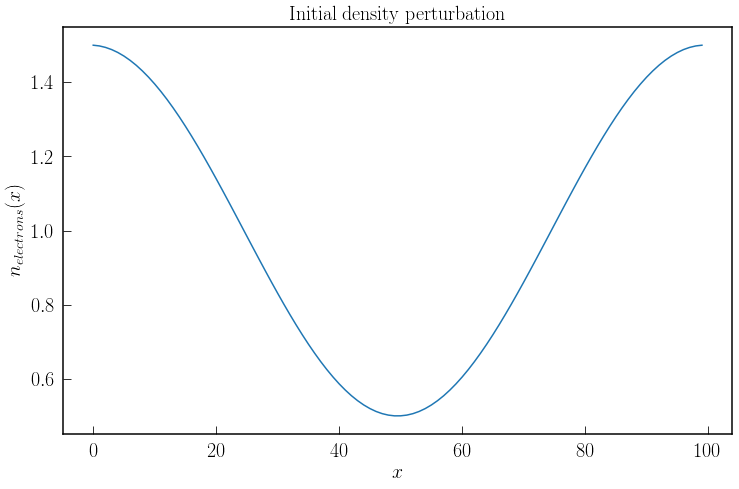

In [18]:
# # Plotting the initial density perturbation
pl.plot(number_density, label = r'$n$')
pl.title(r'$\mathrm{Initial\;density\;perturbation}$')
pl.xlabel('$x$')
pl.ylabel(r'$n_{electrons}(x)$')
pl.show()
pl.clf()

In [19]:
# Time parameters
start_time = 0

end_time   = 1

dt         = 0.002

time       = np.arange(    start_time,\
                           end_time + dt,\
                           dt,\
                           dtype = np.double\
                      )

In [20]:
# Some variables for storing data
Ex_max       = np.zeros(len(time), dtype = np.double)
Ey_max       = np.zeros(len(time), dtype = np.double)

In [21]:
# Charge deposition using linear weighting scheme

rho_electrons  = cloud_charge_deposition(charge_electron,\
                            number_of_electrons,\
                            positions_x,\
                            positions_y,\
                            x_grid,\
                            y_grid,\
                            charge_b1_depositor,\
                            ghost_cells,\
                            length_domain_x,\
                            length_domain_y,\
                            dx,\
                            dy\
                           )
rho_initial    = norm_background_ions(rho_electrons, number_of_electrons, w_p, charge_electron) 

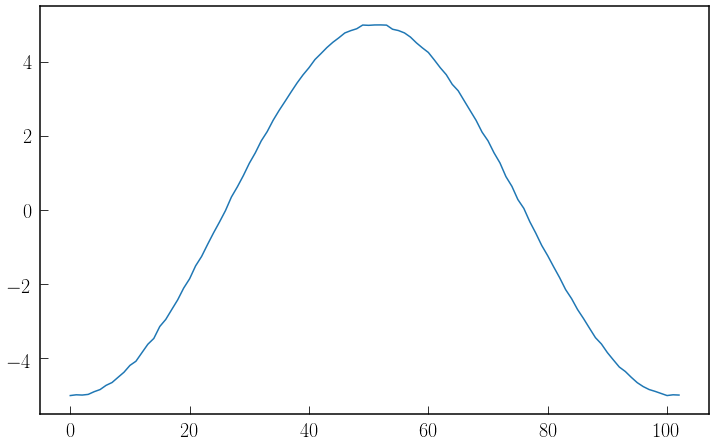

In [22]:
# # plotting intial rho in the system considering background ions
pl.plot(np.array(rho_initial)[1, :])
pl.show()
pl.clf()

In [23]:
# Computing the initial electric fields Ex and Ey
Ex_initial_centered = af.data.constant(0, y_grid.elements(), x_grid.elements(), dtype = af.Dtype.f64)
Ey_initial_centered = af.data.constant(0, y_grid.elements(), x_grid.elements(), dtype = af.Dtype.f64)

rho_physical = rho_initial[ghost_cells:-ghost_cells, ghost_cells:-ghost_cells].copy()

Ex_temp, Ey_temp = fft_poisson(rho_physical, dx, dy)

Ex_initial_centered[ghost_cells:-ghost_cells\
                    ,ghost_cells:-ghost_cells\
                   ]                           = Ex_temp.copy()

Ey_initial_centered[ghost_cells:-ghost_cells\
                    ,ghost_cells:-ghost_cells\
                   ]                           = Ey_temp.copy()

Ex_initial_centered = periodic_ghost(Ex_initial_centered, ghost_cells)
Ey_initial_centered = periodic_ghost(Ey_initial_centered, ghost_cells)

rho.dims() is  (2, 101)


In [24]:
# Bringing Ex_initial_centered, Ey_initial_centered to Yee grid
Ex_initial_Yee = 0.5 * (Ex_initial_centered + af.shift(Ex_initial_centered, 0, -1))
Ex_initial_Yee = periodic_ghost(Ex_initial_Yee, ghost_cells)

Ey_initial_Yee = 0.5 * (Ey_initial_centered + af.shift(Ey_initial_centered, -1, 0))
Ey_initial_Yee = periodic_ghost(Ey_initial_Yee, ghost_cells)

In [25]:
Bz_initial_Yee = 0 * Ex_initial_Yee.copy()

The following cell block determines $v(\frac{\Delta t}{2})$:
\begin{align}
v(\frac{\Delta t}{2}) = v(t = 0) + E_{x}\left(x(\frac{\Delta t}{2})\right)\frac{\Delta t}{2}
\end{align}

In [26]:
# This cell block is to obtain v at (t = 0.5dt) to implement the verlet algorithm.

positions_x_half = positions_x + velocity_x * dt/2
positions_y_half = positions_y + velocity_y * dt/2

# Periodic Boundary conditions for particles 

positions_x_half, positions_y_half = periodic_particles(positions_x_half,\
                                                        positions_y_half,\
                                                        length_domain_x,\
                                                        length_domain_y\
                                                       )

# Finding interpolant fractions for the positions

fracs_Ex_x, fracs_Ex_y = fraction_finder(positions_x_half,\
                                         positions_y_half, \
                                         x_right, y_grid,\
                                         dx, dy\
                                        )

fracs_Ey_x, fracs_Ey_y = fraction_finder(positions_x_half,\
                                         positions_y_half, \
                                         x_grid, y_top,\
                                         dx, dy\
                                        )


fracs_Bz_x, fracs_Bz_y = fraction_finder(positions_x_half,\
                                         positions_y_half,\
                                         x_right, y_top,\
                                         dx, dy\
                                        )
# Interpolating the fields at each particle

Ex_particle = af.signal.approx2(Ex_initial_Yee, fracs_Ex_y, fracs_Ex_x)
Ey_particle = af.signal.approx2(Ey_initial_Yee, fracs_Ey_y, fracs_Ey_x)
Bz_particle = af.signal.approx2(Bz_initial_Yee, fracs_Bz_y, fracs_Bz_x)

# Updating the velocity using the interpolated Electric fields to find v at (t = 0.5dt)

velocity_x, velocity_y =  Boris( charge_electron, mass_electron,\
                                 velocity_x, velocity_y, dt/2,\
                                 Ex_particle, Ey_particle, Bz_particle\
                               )


Ex = Ex_initial_Yee.copy()
Ey = Ey_initial_Yee.copy()
Bz = 0 * Ey_initial_Yee.copy()

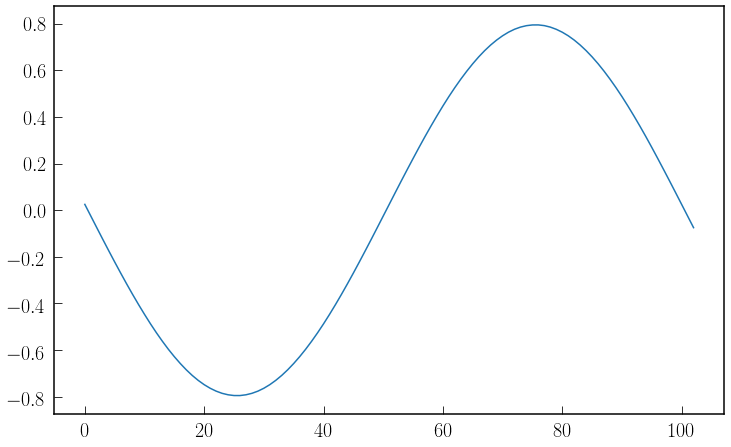

In [27]:
pl.plot(np.array(Ex_initial_Yee)[1, :])
pl.show()
pl.clf()

In [28]:
for time_index in range(len(time)):
    if(time_index%25 ==0):
        print('Computing for time = ', time_index * dt)
        

    # Updating the positions of particle using the velocites (Verlet algorithm)
    # velocity at t = (n + 1/2) dt, positions_x at t = (n)dt and positions_x_new
    # at t = (n+1)dt
    positions_x_new = positions_x + velocity_x * dt
    positions_y_new = positions_y + velocity_y * dt

    # Periodic Boundary conditions for particles
    positions_x_new, positions_y_new = periodic_particles(positions_x_new, positions_y_new,\
                                                          length_domain_x, length_domain_y\
                                                         )

    # Computing the current densities on the Yee grid provided by Umeda's scheme

    Jx_Yee, Jy_Yee = Umeda_2003( charge_electron,\
                                             number_of_electrons,\
                                             positions_x, positions_y,\
                                             velocity_x, velocity_y,\
                                             x_grid, y_grid,\
                                             ghost_cells,\
                                             length_domain_x, length_domain_y,\
                                             dx, dy,\
                                             dt \
                                            )

    # Normalizing and evaluation of current densities on the centered grid

    Jx_norm_Yee = current_norm_BC_Jx(Jx_Yee, number_of_electrons, w_p, ghost_cells)
    Jy_norm_Yee = current_norm_BC_Jy(Jy_Yee, number_of_electrons, w_p, ghost_cells)

    # Evolving electric fields using currents
    
    Ex_updated, Ey_updated, Bz_updated = fdtd(Ex, Ey, Bz, length_domain_x,\
                                              length_domain_y, ghost_cells,\
                                              Jx_norm_Yee, Jy_norm_Yee,\
                                              dt\
                                             )

    # Forcing Bz to be zero
    Bz_updated[:,:] = 0
    
    # calculating the interpolation fraction needed for arrayfire's 1D interpolation
    
    fracs_Ex_x, fracs_Ex_y = fraction_finder(positions_x_new, positions_y_new,\
                                             x_right, y_grid, dx, dy\
                                            )

    fracs_Ey_x, fracs_Ey_y = fraction_finder(positions_x_new, positions_y_new,\
                                             x_grid, y_top, dx, dy\
                                            )

    fracs_Bz_x, fracs_Bz_y = fraction_finder(positions_x_new, positions_y_new,\
                                             x_right, y_top, dx, dy\
                                            )


    # Interpolating the fields at particle locations
    
    Ex_particle = af.signal.approx2(Ex_updated, fracs_Ex_y, fracs_Ex_x)

    Ey_particle = af.signal.approx2(Ey_updated, fracs_Ey_y, fracs_Ey_x)
    
    # Computing the interpolated magnetic field at t = (n+1)*dt to push v((n+1/2) * dt)
    
    Bz_particle = af.signal.approx2((Bz_updated + Bz)/2, fracs_Bz_y, fracs_Bz_x)

    # Updating the velocity using the interpolated Electric fields

    velocity_x_new, velocity_y_new = Boris( charge_electron, mass_electron,\
                                            velocity_x, velocity_y, dt,\
                                            Ex_particle, Ey_particle, Bz_particle\
                                          )

    # Saving the Electric fields for plotting

    Ex_max[time_index]       = (af.max(af.abs(Ex[ghost_cells:-ghost_cells,\
                                                 ghost_cells:-ghost_cells]\
                                             )\
                                      )\
                               )
    
    Ey_max[time_index]       = (af.max(af.abs(Ey[ghost_cells:-ghost_cells,\
                                                 ghost_cells:-ghost_cells]\
                                             )\
                                      )\
                               )
    
    # Saving the updated velocites for the next timestep
    velocity_x  = velocity_x_new.copy()
    positions_x = positions_x_new.copy()
    velocity_y  = velocity_y_new.copy()
    positions_y = positions_y_new.copy()
    Ex          = Ex_updated.copy()
    Ey          = Ey_updated.copy()

Computing for time =  0.0
Computing for time =  0.05
Computing for time =  0.1
Computing for time =  0.15


RuntimeError: In function af_err af_moddims(void**, af_array, unsigned int, const dim_t*)
In file src/api/c/moddims.cpp:68
Invalid dimension for argument 1
Expected: in_elements == new_elements


### Comparing the plots from both Linear theory calculations and Electrostatic PIC below

In [ ]:
h5f = h5py.File('PIC_2D_CD.h5', 'w')
h5f.create_dataset('Ex_amp', data = (Ex_max))
h5f.create_dataset('Ey_amp', data = (Ey_max))
h5f.close()

In [ ]:
# Reading data generated by the Cheng Knorr code
h5f = h5py.File('CK_256.h5', 'r')
Ex_max_CK = h5f['max_E'][:]
h5f.close()
time_CK = np.linspace(0,time[-1], len(Ex_max_CK))

In [ ]:
time_grid = np.linspace(0, time[-1], len(Ex_max))
pl.plot(time_grid, Ex_max , label = r'$\mathrm{PIC}$')
# pl.plot(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.plot(time_CK, Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
# print('(abs(Ex_amplitude[0])) is ',(abs(Ex_amplitude[0])))
# print('(abs(Ex_max[0])) is ',(abs(Ex_max[0])))
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
pl.legend()
pl.show()
pl.savefig('MaxE.png')
pl.clf()

In [ ]:
pl.semilogy(time_grid, Ex_max ,label = r'$\mathrm{PIC}$')
# pl.semilogy(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.semilogy(time_CK,Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
pl.legend()
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
pl.show()
pl.savefig('MaxE_semilogy.png')
pl.clf()

In [ ]:
pl.loglog(time_grid, Ex_max ,label = r'$\mathrm{PIC}$')
# pl.loglog(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.semilogy(time_CK,Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
pl.legend()
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
pl.show()
pl.savefig('MaxE_loglog.png')
pl.clf()